In [1]:
import sys
sys.path.append("../src")

In [2]:
from pathlib import Path
from collections import defaultdict

from gensim.corpora import MmCorpus, Dictionary
from gensim.models.ldamodel import LdaModel
import h5py

from sqlalchemy import Column, Integer, String, ForeignKey, Boolean, Float
from sqlalchemy import create_engine, func
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import relationship
from sqlalchemy.orm import sessionmaker

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import pyLDAvis.gensim

/Users/abuonomo/code/DataSquad/astro2020/venv/lib/python3.7/site-packages/_pytest/mark/structures.py:380: DeprecationWarning: The usage of `cmp` is deprecated and will be removed on or after 2021-06-01.  Please use `eq` and `order` instead.
  @attr.s(cmp=False, hash=False)


In [3]:
import db

/Users/abuonomo/code/DataSquad/astro2020/venv/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
/Users/abuonomo/code/DataSquad/astro2020/venv/lib/python3.7/site-packages/nltk/lm/counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence, defaultdict
/Users/abuonomo/code/DataSquad/astro2020/venv/lib/python3.7/site-packages/tqdm/std.py:651: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
import imp; imp.reload(db)

<module 'db' from '../src/db.py'>

In [5]:
# prepared_data_dir = Path("../scratch/prepared_data/")

# # corpus = MmCorpus('../scratch/prepared_data/corpus.mm')
# # dictionary = Dictionary.load("../scratch/prepared_data/dct.mm")
# corpus, dictionary, corp2paper, dct2kwd = db.read_from_prepared_data(prepared_data_dir)
# mdir = Path('../scratch/tmodels/')
# n_topics = 20
# tmodel_loc = mdir / f'topic_model{n_topics}'

# lda_model = LdaModel.load(str(tmodel_loc))
# tm = db.TopicModeler(dictionary, corpus)
# embedding = tm.get_inference(lda_model)
# coh_per_topic = tm.get_coherence_model(lda_model).get_coherence_per_topic()

# viz_data = pyLDAvis.gensim.prepare(lda_model, tm.corpus, tm.dictionary, doc_topic_dist=np.matrix(embedding), sort_topics=False, mds="mmds", start_index=0)

# # pyLDAvis.save_html(viz_data, str(viz_loc))

# db_loc = '../scratch/test.sqlite'


# corp2paper_dct = {c: p for c, p in corp2paper}
# dct2kwd_dct = {d: k for d, k in dct2kwd}

# corpus_inds, paper_inds = zip(*corp2paper)

# # engine = create_engine(f"sqlite:///{db_loc}")
# # Session = sessionmaker(bind=engine)
# # session = Session()

# # session.query(db.Paper.id).count()
# # paper2bibcodeode = session.query(db.Paper.id, db.Paper.bibcode).all()

# # q = (
# #     session.query(db.Paper.bibcode)
# #     .filter(db.Paper.id.in_([p for _, p in corp2paper]))
# # )
# # bibs = [q[0] for q in q.all()]

# # bibs = [[c, paper2bibcode_dct[p]] for c, p in corp2paper]

# # bibs = [paper2bibcode_dct[p] for c, p in corp2paper]

# embedding_df = pd.DataFrame(embedding)
# embedding_df.index = paper_inds

# db_loc = '../scratch/test.sqlite'

# embedding_df

# engine = create_engine(f"sqlite:///{db_loc}")
# Session = sessionmaker(bind=engine)
# session = Session()

# session.query(db.Paper.id).count()
# # paper2bibcode = session.query(db.Paper.id, db.Paper.bibcode).all()

# st = session.query(db.Paper.id, db.Paper.bibcode, db.Paper.year).statement

# viz_data[2].to_hdf('test.hdf', key='kwd2topic')

# pd.read_sql(st, con=engine).to_hdf('test.hdf', key='id2bibcode2year', format='table')

# embedding_df.to_hdf('test.hdf', key='embedding')

# pd.read_hdf('test.hdf', key='embedding')

In [6]:
# with h5py.File('test.hdf', 'r') as f0:
#     print(f0['id2bibcode2year'].keys())
#     pby = f0['id2bibcode2year']['table'][:]
#     pby2 = f0['id2bibcode2year']['_i_table']
#     print(pby2['index'])
#     print(pby['table'][:])

In [7]:
# pby

# pby[]

In [8]:
# pby.name

# pd.read_hdf('test.hdf', key='id2bibcode2year')

# Get Keyword Time Series as well

# Get Topic Years

In [9]:
from tsfresh import extract_features
import numpy as np

In [10]:
thresh = 0.3

year_min = 1997
year_max = 2010

In [12]:
# get all papers to years and keep in memory. Filter on the fly

In [13]:
vis_data_loc = '../scratch/vis_data.hdf5'

with h5py.File(vis_data_loc, 'r') as f0:
    embedding = f0['embedding'][:]
    topic_coherences = f0['topic_coherences'][:]
    paper_inds = f0['paper_inds'][:]
#         f0.create_dataset("embedding", dtype=np.float, data=embedding)
#     f0.create_dataset("topic_coherences", dtype=np.float, data=coh_per_topic)
#     f0.create_dataset("paper_inds", dtype=np.int, data=paper_inds)
pyLDAvis_features = pd.read_hdf(vis_data_loc, key='pyLDAvis_features')
pby = pd.read_hdf(vis_data_loc, key='paper2bibcode2year')

embedding_df = pd.DataFrame(embedding)
embedding_df.index = paper_inds

all_time_series = []
for topic in tqdm(embedding_df.columns):
    ids_in_topic = embedding_df.index[embedding_df.loc[:, topic] > thresh].tolist() # function to include options with argmax as well?
    year_counts = pby.loc[(pby['id'].isin(ids_in_topic)) & (pby['year'] >= year_min) & (pby['year'] <= year_max)].groupby('year').count()['id']
    year_counts = year_counts.reset_index().to_records()
    ycd = defaultdict(int, {y:c for _, y, c in year_counts})
    topic_time_series = [{"topic": topic, "year": y, "count": ycd[y]} for y in range(year_min, year_max)]
    all_time_series = all_time_series + topic_time_series

ts_df_long = pd.DataFrame(all_time_series)
ts_df = ts_df_long.pivot(index='topic', columns="year", values="count")

features_df = extract_features(ts_df_long, column_id='topic', column_sort='year')
features_df['coherence_score'] = topic_coherences

def cagr(x_row):
    x = x_row.values
    nz_inds = np.nonzero(x)[0]
    if len(nz_inds) == 0:  # If all are 0, set CAGR to 0
        return 0
    else:
        first_nonzero_index = nz_inds[0]
        x = x[first_nonzero_index:]  # Not valid if starts with 0. Becomes inf
        x = x[~np.isnan(x)]  # For normalized time series, NaNs before any occurrence of kwd
    if len(x) < 2:  # If no periods, set CAGR to 0
        return 0
    else:
        ys = x_row.index
        period = max(ys) - min(ys)
        return (x[-1] / x[0]) ** (1 / period) - 1

features_df['CAGR'] = ts_df.apply(cagr, axis=1)

In [52]:
import dtw_time_analysis as dtw
import imp; imp.reload(dtw)
from analyze_keyword_time_series import yellow_plot_kmd

/Users/abuonomo/code/DataSquad/astro2020/venv/lib/python3.7/site-packages/ipyvolume/transferfunction.py:46: DeprecationWarning: Traits should be given as instances, not types (for example, `Int()`, not `Int`). Passing types is deprecated in traitlets 4.1.
  levels = traitlets.List(traitlets.CFloat, default_value=[0.1, 0.5, 0.8]).tag(sync=True)
/Users/abuonomo/code/DataSquad/astro2020/venv/lib/python3.7/site-packages/ipyvolume/transferfunction.py:47: DeprecationWarning: Traits should be given as instances, not types (for example, `Int()`, not `Int`). Passing types is deprecated in traitlets 4.1.
  opacities = traitlets.List(traitlets.CFloat, default_value=[0.01, 0.05, 0.1]).tag(sync=True)
/Users/abuonomo/code/DataSquad/astro2020/venv/lib/python3.7/site-packages/ipyvolume/transferfunction.py:48: DeprecationWarning: Traits should be given as instances, not types (for example, `Int()`, not `Int`). Passing types is deprecated in traitlets 4.1.
  widths = traitlets.List(traitlets.CFloat, def

In [53]:
dtw_df = dtw.dtw_kwds(ts_df)

INFO:dtw_time_analysis:Computing dynamic time warping between keywords.
INFO:dtw_time_analysis:window: 1.


INFO:analyze_keyword_time_series:Trying kmeans n_clusters from 2 to 20
INFO:analyze_keyword_time_series:Writing elbow to None.


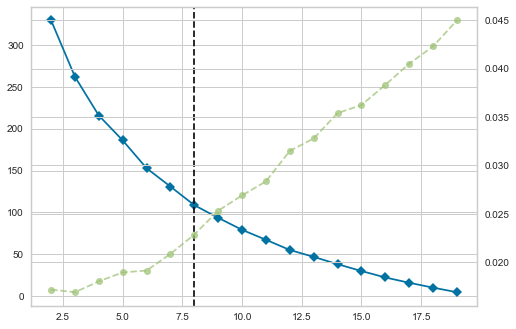

In [55]:
visualizer = yellow_plot_kmd(dtw_df)

In [56]:
from analyze_keyword_time_series import dtw_to_tboard, dtw_to_manifold

In [57]:
n_clusters = visualizer.elbow_value_

INFO:analyze_keyword_time_series:Performing kmeans with 8 clusters.
INFO:analyze_keyword_time_series:Computing tsne manifold.


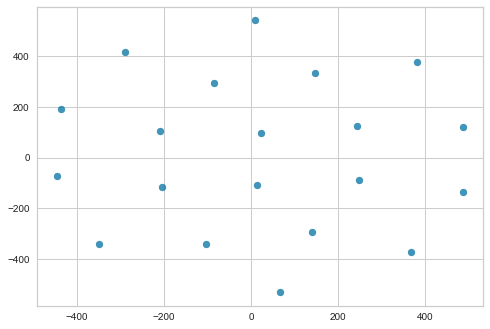

In [58]:
kmeans = dtw_to_tboard(ts_df, dtw_df, c=n_clusters)  # c taken from elbow viz
dtw_man = dtw_to_manifold(dtw_df)

In [59]:
dtw_man # add manifold points to features dataframe

array([[ 247.25104 ,  -90.13529 ],
       [-436.23248 ,  190.75902 ],
       [ 486.12115 , -134.1303  ],
       [-210.49738 ,  104.46882 ],
       [ 145.43713 ,  332.59753 ],
       [ 243.33751 ,  125.321785],
       [-350.5686  , -340.42874 ],
       [ 485.4688  ,  122.518456],
       [ 381.85147 ,  378.73666 ],
       [  12.842705, -110.08366 ],
       [ 139.81805 , -293.2926  ],
       [-289.07437 ,  418.29407 ],
       [ -85.189125,  294.80228 ],
       [  65.232346, -531.4616  ],
       [   8.207455,  541.28815 ],
       [-104.932335, -340.7562  ],
       [-204.72101 , -115.0054  ],
       [  22.947538,   97.1475  ],
       [-446.21582 ,  -73.40713 ],
       [ 366.99673 , -374.63455 ]], dtype=float32)